In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
%matplotlib inline

# Creating playing environment

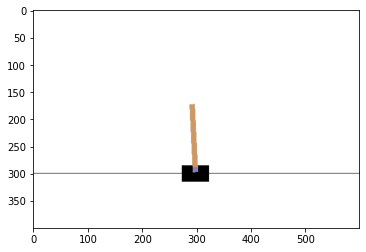

In [2]:
env = gym.make("CartPole-v0")

if hasattr(env, '_max_episode_steps'):
    env = env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Creating an agent

In [3]:
class ReinforceAgent:
    def __init__(self, state_dim, n_actions,alpha=0.1):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.alpha = alpha
        self.sess = tf.InteractiveSession()
        self.ph_states, self.ph_actions, self.ph_cumulative_rewards = self.init_placeholders()
        self.policy, self.log_policy  = self.make_model()
        self.update = self.init_graph()
        self.sess.run(tf.global_variables_initializer())
        
    def make_model(self):
        model = Sequential()
        model.add(InputLayer(input_shape=self.state_dim))
        model.add(Dense(units=200,activation='relu'))
        model.add(Dense(units=150,activation='relu'))
        model.add(Dense(units=75,activation='relu'))
        model.add(Dense(units=self.n_actions))
        logits = model(self.ph_states) 
        policy = tf.nn.softmax(logits)
        log_policy = tf.nn.log_softmax(logits)
        self.sess.run(tf.global_variables_initializer())
        return policy, log_policy 
    
    def init_placeholders(self):
        ph_states = tf.placeholder('float32', (None,) + self.state_dim, name="states")
        ph_actions = tf.placeholder('int32', name="action_ids")
        ph_cumulative_rewards = tf.placeholder('float32', name="cumulative_returns")
        return ph_states, ph_actions, ph_cumulative_rewards
    
    def init_graph(self):
        indices = tf.stack([tf.range(tf.shape(self.log_policy)[0]), self.ph_actions], axis=-1)
        log_policy_for_actions = tf.gather_nd(self.log_policy, indices)
        J = tf.reduce_mean(log_policy_for_actions*self.ph_cumulative_rewards,axis=-1)
        entropy = - tf.reduce_mean(self.policy*self.log_policy)
        loss = -(J + self.alpha * entropy)
        update = tf.train.AdamOptimizer().minimize(loss)
        return update
    
    def train(self, states, actions, cumulative_rewards):
         self.update.run({
                self.ph_states: states,
                self.ph_actions: actions,
                self.ph_cumulative_rewards: cumulative_rewards,
                        })
    
    def predict(self, s):
        probs = self.policy.eval({self.ph_states: [s]})[0]
        action = np.random.choice(a=self.n_actions,p=probs)
        return action

# Training an agent

In [4]:
gamma = 0.99
alpha = 0.1

In [5]:
agent = ReinforceAgent(n_actions=n_actions,state_dim=state_dim,alpha=alpha)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [6]:
def generate_session(agent, env, t_max=1000):
    """ 
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s = env.reset()

    for t in range(t_max):
        a = agent.predict(s)
        new_s, r, done, info = env.step(a)
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [7]:
def get_cumulative_rewards(rewards,  
                           gamma=0.99  
                           ):
    """
    Take a list of immediate rewards r(s,a) for the whole session 
    and compute cumulative returns 
    """
    cum_rewards = [rewards[-1]]
    for t, r in enumerate(rewards[::-1]):
        g_t = r+gamma*cum_rewards[t]
        cum_rewards.append(g_t)
    return cum_rewards[1:][::-1]

In [12]:
def train(agent,env, gamma=0.99, num_epochs=100, ep_per_epoch=100):
    for epoch in range(num_epochs):
        global_rewards = []
        for episode in range(ep_per_epoch):
            states, actions, rewards = generate_session(agent, env)
            returns = get_cumulative_rewards(rewards,gamma)
            agent.train(states,actions,returns)
            global_rewards.append(sum(rewards))
            

        print("mean reward: %.3f" % (np.mean(global_rewards)))
        if np.mean(global_rewards) > 300:
            print("You Win!")  # 
            break

In [13]:
train(agent,env)

mean reward: 175.860
mean reward: 90.790
mean reward: 93.710
mean reward: 114.130
mean reward: 90.010
mean reward: 151.560
mean reward: 595.890
You Win!


# Visualization of process